# Audio Classifier Model

In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
%matplotlib inline
#CLass used to tweak hyperparameters easily
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        #mode is the neural network we are going to use (between convolutional and recurrent)
        self.mode = mode
        #nfilt is the nb of filters used for the mel filter bank
        self.nfilt = nfilt
        #nfeat is the nb of filter kept for the mel cepstrum coefficient
        self.nfeat = nfeat
        #nfft is the nb of points inside a window
        self.nfft = nfft
        #rate is the sampling rate in Hz
        self.rate = rate
        #number of sampels in a window
        self.step = int(rate/10)
def generate_features(mode='train'):
    X = []
    y = []
    _min, _max = float('inf'), float('-inf')
    for _ in tqdm(range(n_samples)):
        #pick randomly a class based on the mean record length of each class
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        #pick randomly a file from the class chosen 
        file = np.random.choice(df[df.label == rand_class].index)
        #load the file
        if mode=='train':
            rate, wav = wavfile.read('/home/romain/TF Notebooks/Audio Classifier/clean/'+file)
        else :
            rate, wav = wavfile.read('/home/romain/TF Notebooks/Audio Classifier/clean_test/'+file)
        #get the label of the chosen file
        label = df.at[file,'label']
        #pick the index of where to start the window in our sample
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        #get all the data points within the window
        sample = wav[rand_index:rand_index + config.step]
        #convert sample to mfcc sample
        X_sample = mfcc(sample, rate, numcep=config.nfeat,nfilt=config.nfilt, nfft=config.nfft).T
        #compare min and max value of current sample with min and max values of all samples
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        #add feature to global array, transpose the matrix or not depending on the type of NN used
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        #add number label corresponding to string label to global array
        y.append(classes.index(label))
    #convert arrays to numpy arrays
    X,y = np.array(X), np.array(y)
    #normalize the samples between 0 and 1 values
    X = (X - _min) / (_max - _min)
    if config.mode=='conv':
        #Add the 1 pixel for CNN (always put a constant 1 in the input for CNN)
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
        #OneHot encoding of the label for the cost function
    y = to_categorical(y, num_classes=10)
    return X,y

def get_cnn_model():
    #allows to stack up layers without specifying which ones are connected to which ones
    model = Sequential()
    #Convlayers
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    #pooling layer
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    #dense layers
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    #optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

def get_rnn_model():
    #allows to stack up layers without specifying which ones are connected to which ones
    model = Sequential()
    #CNN layers
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

df = pd.read_csv('/home/romain/TF Notebooks/Audio Classifier/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('/home/romain/TF Notebooks/Audio Classifier/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate
# sum up the lenght of all samples, divide it by window size to get number of total windows, and multiply by 2 to have enough samples
n_samples = 2 * int(df['length'].sum() / 0.1)
#Create a list of all possible classes
classes = list(np.unique(df.label))
#get the mean length of a record for each classes
class_dist = df.groupby(['label'])['length'].mean()
#convert the mean length to a float between 0 and 1
prob_dist = class_dist / class_dist.sum()
#pick randomly a class based on the mean record length of each class
choices = np.random.choice(class_dist.index, p= prob_dist)




Using TensorFlow backend.


# Creating the model

In [2]:
config = Config(mode='conv')
# get the preprocessed features and labels
X,y = generate_features('train')
df = pd.read_csv('/home/romain/TF Notebooks/Audio Classifier/test.csv')
df.set_index('fname',inplace=True)
for f in df.index:
    rate, signal = wavfile.read('/home/romain/TF Notebooks/Audio Classifier/clean_test/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate
# sum up the lenght of all samples, divide it by window size to get number of total windows, and multiply by 2 to have enough samples
n_samples = 2 * int(df['length'].sum() / 0.1)
#Create a list of all possible classes
classes = list(np.unique(df.label))
#get the mean length of a record for each classes
class_dist = df.groupby(['label'])['length'].mean()
#convert the mean length to a float between 0 and 1
prob_dist = class_dist / class_dist.sum()
#pick randomly a class based on the mean record length of each class
choices = np.random.choice(class_dist.index, p= prob_dist)
X_test,y_test = generate_features('test')
if config.mode == 'conv':
    #convert OneHot back to normal
    y_flat = np.argmax(y, axis=1)
    #shape parameter for CNN model (drop the nb of samples from the shape)
    input_shape = (X.shape[1],X.shape[2],1)
    #get the model
    model = get_cnn_model()
elif config.mode == 'time':
    #convert OneHot back to normal
    y_flat = np.argmax(y, axis=1)
    #shape parameter for CNN model (drop the nb of samples from the shape)
    input_shape = (X.shape[1],X.shape[2])
    #get the model
    model = get_rnn_model()    

100%|██████████| 52584/52584 [02:53<00:00, 310.24it/s]


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)  

# Training  the model

In [41]:
#get the weight of each classes
class_weight = compute_class_weight('balanced',np.unique(y_flat), y_flat)
#fit the model
model.fit(X, y, epochs=10, batch_size=32, shuffle = True, class_weight = class_weight, validation_split=0.1)

Train on 47325 samples, validate on 5259 samples
Epoch 1/10
47325/47325 [==============================] - 76s 2ms/step - loss: 0.6555 - acc: 0.7674 - val_loss: 0.3726 - val_acc: 0.8701
Epoch 2/10
47325/47325 [==============================] - 75s 2ms/step - loss: 0.3852 - acc: 0.8630 - val_loss: 0.3255 - val_acc: 0.8914
Epoch 3/10
47325/47325 [==============================] - 76s 2ms/step - loss: 0.2988 - acc: 0.8947 - val_loss: 0.2673 - val_acc: 0.9080
Epoch 4/10
47325/47325 [==============================] - 77s 2ms/step - loss: 0.2463 - acc: 0.9128 - val_loss: 0.1893 - val_acc: 0.9325
Epoch 5/10
47325/47325 [==============================] - 70s 1ms/step - loss: 0.2236 - acc: 0.9203 - val_loss: 0.1816 - val_acc: 0.9418
Epoch 6/10
47325/47325 [==============================] - 76s 2ms/step - loss: 0.2048 - acc: 0.9270 - val_loss: 0.1554 - val_acc: 0.9523
Epoch 7/10
47325/47325 [==============================] - 77s 2ms/step - loss: 0.1815 - acc: 0.9360 - val_loss: 0.1484 - val_acc:

# Predictions

In [63]:
predictions = model.predict(X,batch_size=32)
label = []
for p in predictions:
    maximum = np.max(p)
    label.append(np.where(maximum == p)[0])
true_label = []
for l in y:
    maximum = np.max(l)
    true_label.append(np.where(maximum == l)[0])
errors = 0
for i in range(len(label)):
    if label[i] != true_label[i]:
        errors = errors + 1
print("Accuracy : "+str((len(label)-errors)/len(label) * 100)+" %")

Accuracy : 54.43392654297614 %


# Confusion Matrix

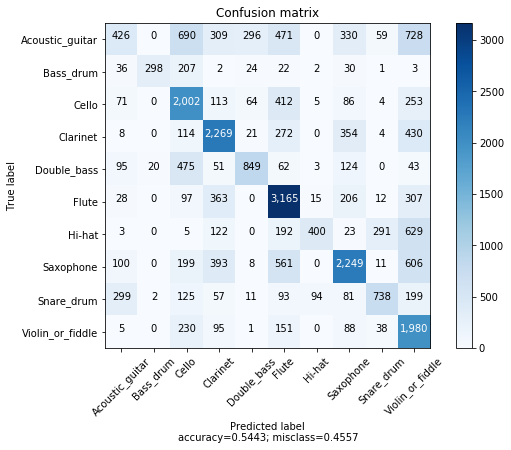

In [64]:
from sklearn import metrics
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
matrix = metrics.confusion_matrix(true_label, label)
plot_confusion_matrix(matrix,classes,normalize=False)